In [9]:
from google.colab import files
uploaded = files.upload()

Saving 9ooB60I.jpeg to 9ooB60I.jpeg
Saving F28w3Ac.jpeg to F28w3Ac.jpeg


In [18]:
!pip install keras-applications

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 3.1 MB/s eta 0:00:00


In [30]:
total_variation_weight = 1e-6
style_weight = 1e-6
content_weight = 2.5e-8


width, height = keras.utils.load_img(base_image_path).size
img_nrows = 400
img_ncols = int(width * img_nrows / height)

In [31]:
import cv2
import os
import numpy
import keras
import tensorflow as tf
from keras.applications import vgg19

base_image_path = "/content/F28w3Ac.jpeg"
style_reference_image_path = "/content/9ooB60I.jpeg"


if not os.path.exists(base_image_path):
    print(f"Error: Base image not found at {base_image_path}")
elif not os.path.exists(style_reference_image_path):
    print(f"Error: Style reference image not found at {style_reference_image_path}")
else:
    print("Images loaded successfully using OpenCV.")

Images loaded successfully using OpenCV.


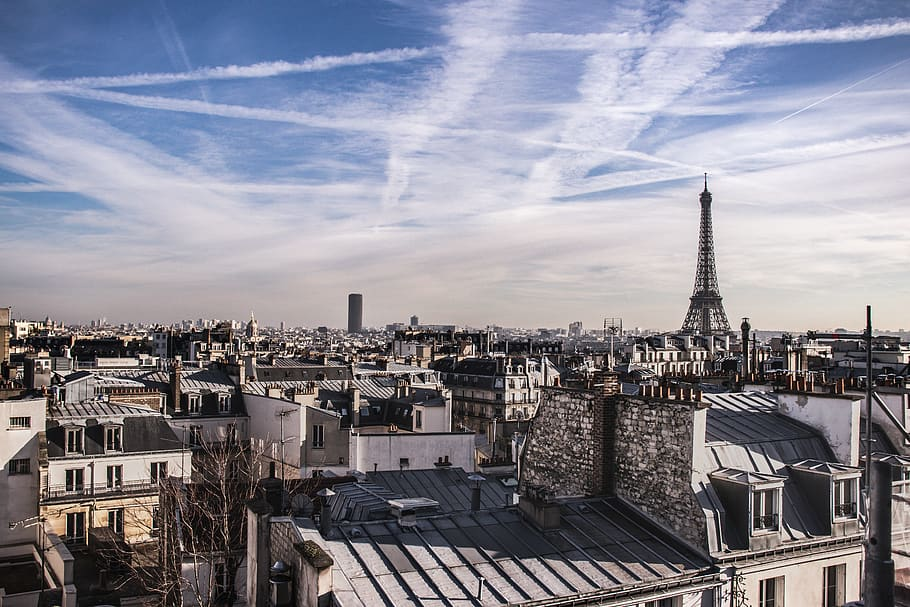

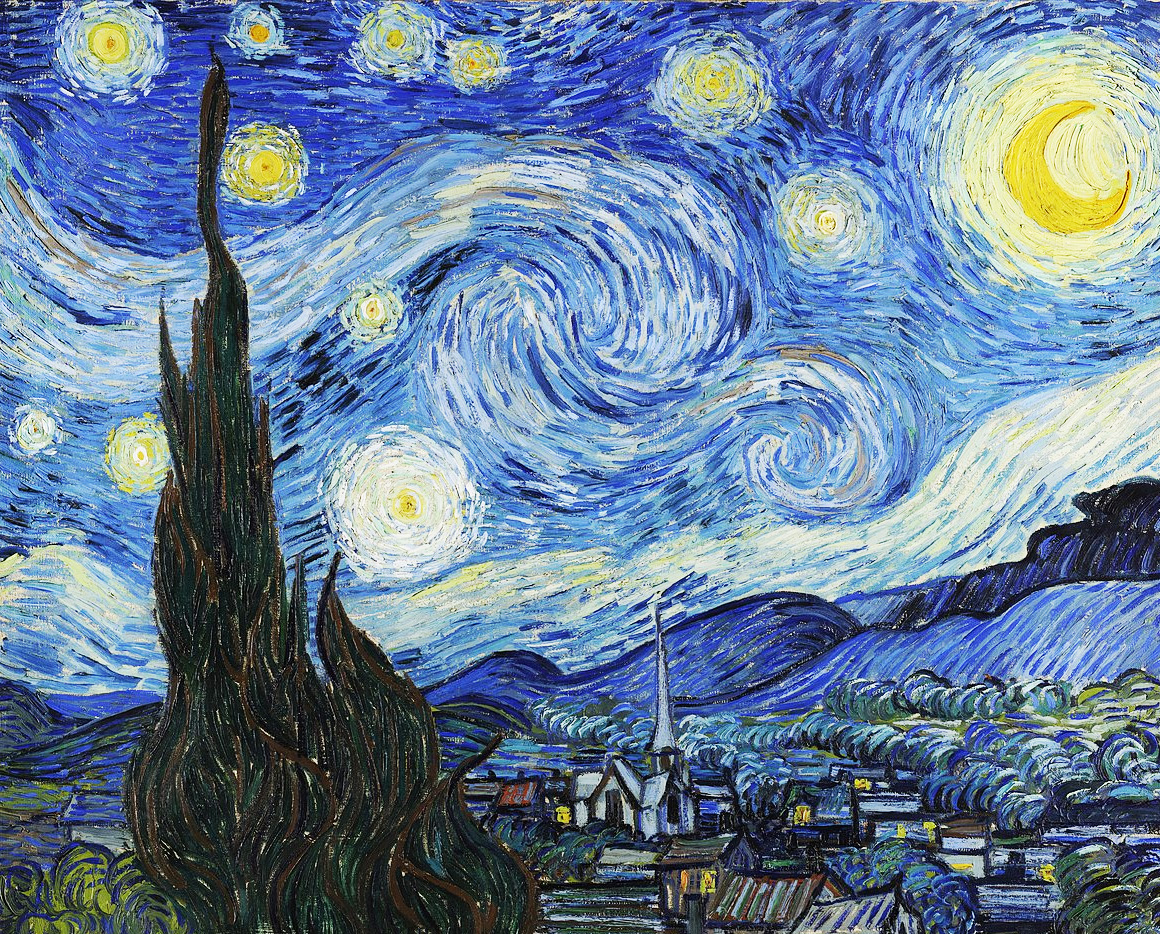

In [32]:
from IPython.display import display, Image
import cv2

base_image = cv2.imread(base_image_path)
style_reference_image = cv2.imread(style_reference_image_path)

if base_image is not None:
    _, base_image_encoded = cv2.imencode('.png', base_image)
    display(Image(data=base_image_encoded.tobytes()))
else:
    print(f"Could not read base image from {base_image_path}")

if style_reference_image is not None:
    _, style_reference_image_encoded = cv2.imencode('.png', style_reference_image)
    display(Image(data=style_reference_image_encoded.tobytes()))
else:
     print(f"Could not read style reference image from {style_reference_image_path}")

In [33]:
def preprocess_image(image_path):

    img = keras.utils.load_img(image_path, target_size=(img_nrows, img_ncols))
    img = keras.utils.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = vgg19.preprocess_input(img)
    return tf.convert_to_tensor(img)


def deprocess_image(x):

    x = x.reshape((img_nrows, img_ncols, 3))

    x[:, :, 0] += 103.939
    x[:, :, 1] += 116.779
    x[:, :, 2] += 123.68

    x = x[:, :, ::-1]
    x = np.clip(x, 0, 255).astype("uint8")
    return x

In [34]:
def gram_matrix(x):
    x = tf.transpose(x, (2, 0, 1))
    features = tf.reshape(x, (tf.shape(x)[0], -1))
    gram = tf.matmul(features, tf.transpose(features))
    return gram




def style_loss(style, combination):
    S = gram_matrix(style)
    C = gram_matrix(combination)
    channels = 3
    size = img_nrows * img_ncols
    return tf.reduce_sum(tf.square(S - C)) / (4.0 * (channels**2) * (size**2))




def content_loss(base, combination):
    return tf.reduce_sum(tf.square(combination - base))





def total_variation_loss(x):
    a = tf.square(
        x[:, : img_nrows - 1, : img_ncols - 1, :] - x[:, 1:, : img_ncols - 1, :]
    )
    b = tf.square(
        x[:, : img_nrows - 1, : img_ncols - 1, :] - x[:, : img_nrows - 1, 1:, :]
    )
    return tf.reduce_sum(tf.pow(a + b, 1.25))

In [35]:

model = vgg19.VGG19(weights="imagenet", include_top=False)


outputs_dict = dict([(layer.name, layer.output) for layer in model.layers])


feature_extractor = keras.Model(inputs=model.inputs, outputs=outputs_dict)

In [36]:
# List of layers to use for the style loss.
style_layer_names = [
    "block1_conv1",
    "block2_conv1",
    "block3_conv1",
    "block4_conv1",
    "block5_conv1",
]

content_layer_name = "block5_conv2"


def compute_loss(combination_image, base_image, style_reference_image):
    input_tensor = tf.concat(
        [base_image, style_reference_image, combination_image], axis=0
    )
    features = feature_extractor(input_tensor)


    loss = tf.zeros(shape=())


    layer_features = features[content_layer_name]
    base_image_features = layer_features[0, :, :, :]
    combination_features = layer_features[2, :, :, :]
    loss = loss + content_weight * content_loss(
        base_image_features, combination_features
    )

    for layer_name in style_layer_names:
        layer_features = features[layer_name]
        style_reference_features = layer_features[1, :, :, :]
        combination_features = layer_features[2, :, :, :]
        sl = style_loss(style_reference_features, combination_features)
        loss += (style_weight / len(style_layer_names)) * sl


    loss += total_variation_weight * total_variation_loss(combination_image)
    return loss

In [37]:
@tf.function
def compute_loss_and_grads(combination_image, base_image, style_reference_image):
    with tf.GradientTape() as tape:
        loss = compute_loss(combination_image, base_image, style_reference_image)
    grads = tape.gradient(loss, combination_image)
    return loss, grads

In [39]:
result_prefix = "paris_generated"

In [40]:
optimizer = keras.optimizers.SGD(
    keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate=100.0, decay_steps=100, decay_rate=0.96
    )
)

base_image = preprocess_image(base_image_path)
style_reference_image = preprocess_image(style_reference_image_path)
combination_image = tf.Variable(preprocess_image(base_image_path))

iterations = 4000
for i in range(1, iterations + 1):
    loss, grads = compute_loss_and_grads(
        combination_image, base_image, style_reference_image
    )
    optimizer.apply_gradients([(grads, combination_image)])
    if i % 100 == 0:
        print("Iteration %d: loss=%.2f" % (i, loss))
        img = deprocess_image(combination_image.numpy())
        fname = result_prefix + "_at_iteration_%d.png" % i
        keras.utils.save_img(fname, img)

Iteration 100: loss=11024.40
Iteration 200: loss=8518.96
Iteration 300: loss=7574.18
Iteration 400: loss=7063.58
Iteration 500: loss=6734.39
Iteration 600: loss=6499.02
Iteration 700: loss=6320.14
Iteration 800: loss=6178.05
Iteration 900: loss=6061.40
Iteration 1000: loss=5963.75
Iteration 1100: loss=5880.76
Iteration 1200: loss=5809.37
Iteration 1300: loss=5747.38
Iteration 1400: loss=5692.92
Iteration 1500: loss=5644.70
Iteration 1600: loss=5601.56
Iteration 1700: loss=5562.83
Iteration 1800: loss=5527.91
Iteration 1900: loss=5496.36
Iteration 2000: loss=5467.71
Iteration 2100: loss=5441.57
Iteration 2200: loss=5417.72
Iteration 2300: loss=5395.87
Iteration 2400: loss=5375.80
Iteration 2500: loss=5357.29
Iteration 2600: loss=5340.17
Iteration 2700: loss=5324.33
Iteration 2800: loss=5309.67
Iteration 2900: loss=5296.03
Iteration 3000: loss=5283.36
Iteration 3100: loss=5271.54
Iteration 3200: loss=5260.48
Iteration 3300: loss=5250.15
Iteration 3400: loss=5240.44
Iteration 3500: loss=5

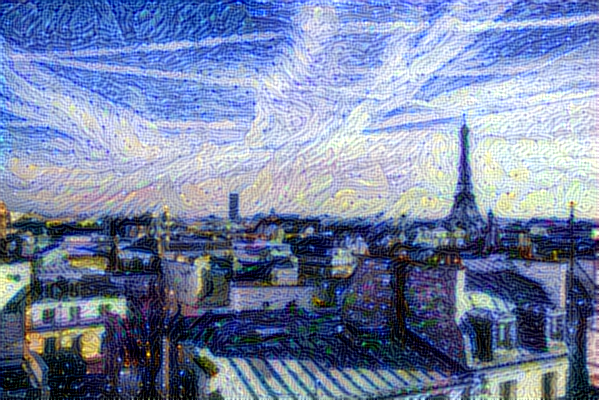

In [41]:
display(Image(result_prefix + "_at_iteration_4000.png"))